# 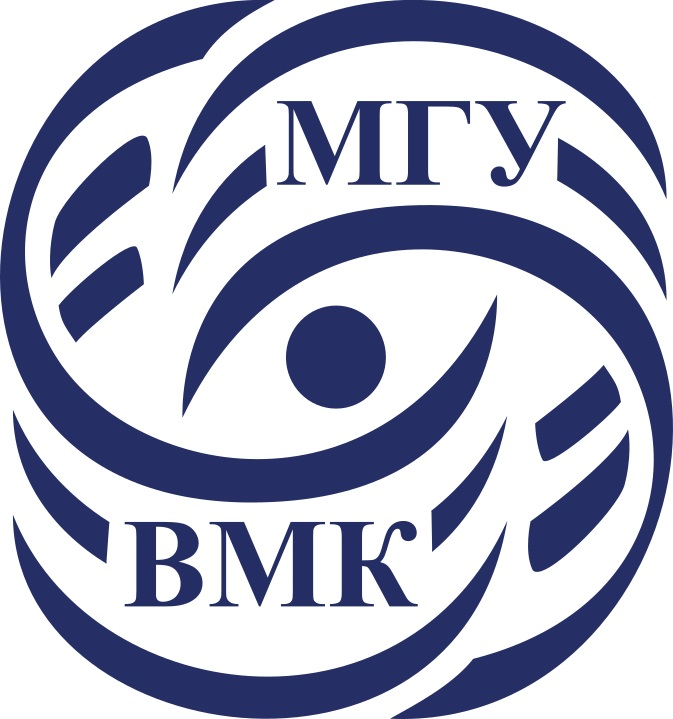

# Машинное обучение. ВМК МГУ

# Практическое задание 8: Градиентный бустинг деревьев

## Важно! О формате сдачи

* Практически все выделенные задания из ноутбука оцениваются по системе <font color='red'>кросс-рецензирования.</font> Задания, в которых надо реализовать свой код и послать в систему, выделены здесь и в PDF отдельно.
* В этом задании также есть задания по типу <font color='red'>ML-решения.</font>
* При решении ноутбука <font color='red'>используйте данный шаблон.</font> Не нужно удалять текстовые ячейки с разметкой частей ноутбука и формулировками заданий. Добавлять свои ячейки, при необходимости, конечно, можно.
* Везде, где в формулировке задания есть <font color='red'>какой-либо вопрос (или просьба вывода),</font> необходимо прописать ответ в ячейку (код или Markdown).
* Наличие <font color='red'>кода решения обязательно.</font> Письменные ответы на вопросы без сопутствующего кода оцениваются в 0 баллов.
* Если в ячейке написана фраза <font color='red'>"Вывод"/"Ответ на вопрос" и.т.д.,</font> то ожидается ответ в виде текста (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если в ячейке написано <font color='red'>"Your code here" и пр. </font>, то ожидается ответ в виде кода (можете добавить ячейки с кодом, если считаете это необходимым, но это необязательно). Если есть и ячейка с фразой "Вывод", и ячейка с фразой "Your code here", то в ответе ожидается и код, и текст

__В этом задании вы..:__

- Познакомитесь с несколькими новыми библиотеками машинного обучения
- Сравните между собой разные реализации градиентных бустингов
- Примените все полученные знания для получения лучшего скора на датасете фильмов


<font color=orange><h3>*Примерное время выполнения (execution time/время выполнения, если нажать run all) всех ячеек ноутбука (без ML-решения): 60 минут*</font></h3>

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Немного магии, которую не надо менять, но надо выполнить перед каждым запуском!

## Подготовка рабочей среды
Сначала установим нужные нам версии библиотек. Мы гарантируем, что в данных версиях задание будет корректно отрабатывать.

После установки нужных версий, **возможно,** нужно перезагрузить среду (runtime), но скорее всего вам это не понадобится


На скачивание файла и установку понадобится не более 5 минут.

**Важно!**
Устанавливать нужные версии нужно каждый раз, когда создается новый рантайм. Например, если вы 2 часа подряд делаете это задание, то подготовить библиотеки достаточно 1 раз. Но если вы, например, начали в понедельник, затем закрыли/выключили ноутбук, то при продолжении в среду, вам нужно будет запустить рантайм заново и следовательно заново установить библиотеки.

**Важно!**
Если вы предпочитаете делать практические задания на своем личном ноутбуке, то проверьте, что вы установили рабочее окружение в [соответствии с гайдом](https://github.com/MSU-ML-COURSE/ML-COURSE-23-24/blob/main/tutorials/Туториал%20по%20установке%20рабочего%20окружения%20в%20Python%20для%20решения%20задач.pdf)

<font color='red'>**Важно!**</font> В файлике requirements_small.txt поменялась версия `gdown` _(в предыдущей версии, к сожалению, стали появляться ошибки при скачивании через эту утилиту)_! Если вы работаете в Google Colab, то ничего дополнительно делать не нужно, если вы работаете локально, то рекомендуем обновить версию `gdown` в виртуальном окружении на `>=4.7.3`. Более подробные инструкции вы найдете в треде по этому заданию в чате курса.

In [ ]:
!pip install --upgrade gdown

In [ ]:
!gdown 1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
!pip install -r /content/requirements_small.txt

Downloading...
From: https://drive.google.com/uc?id=1pIw8GdGKY6fZ_XNPc6snimdV6lbXJ199
To: /content/requirements_small.txt
100% 374/374 [00:00<00:00, 1.04MB/s]


In [ ]:
import catboost
assert(catboost.__version__ == '1.2.1')




# Введение

Привет, ребятушки!

Сегодня мы с вами будем решать очень важную задачу, а именно оценивать цену подержанных автомобилей в ряде стран. Делать мы это будем с помощью различных методов градиентного бустинга. Мы с вами узнаем, что в мире существует не только sklearn, и что существуют библиотеки, облегчающие нам задачу поиска оптимальных параметров для моделей.

**<font color='red'>Внимание!</font> Во всех заданиях в качестве целевой метрики используется MAE (средняя абсолютная ошибка).** Значение MAE вычисляется как

$$
  MAE = \sum_{i = 1}^N\dfrac{|a(x_i) - y_i|}{N},
$$

где $N$ - число объектов в тестовой выборке, $x_i$ - вектор признаков i-го объекта, $a(x_i)$ - предсказание на i-ом объекте, $y_i$ - значение целевого признака на i-м объекте.

## Используемые библиотеки

В этом задании нам понадобятся три библиотеки, которыми вы ранее не пользовались в этом курсе, а именно:

**XGBoost**: Документация [здесь](https://xgboost.readthedocs.io/en/stable/).<br />
**LightGBM**: Документация [здесь](https://lightgbm.readthedocs.io/en/latest/index.html). Также дополнительно про установку [тут](https://pypi.org/project/lightgbm/).<br />
**Catboost**: Документация [здесь](https://catboost.ai/en/docs/). Можно найти также некоторую информацию на русском [тут](https://habr.com/ru/company/otus/blog/527554/).<br />
**HyperOpt**: Документация [здесь](http://hyperopt.github.io/hyperopt/). <br />

<font color='red'>**Внимание!**</font> Вникать и подробно читать документацию к каждой библиотеке нет необходимости! Достаточно обращаться туда для нахождения примеров обучения.


----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

## Различия в методах бустинга

Каждая библиотека, которую мы будем сегодня использовать, имеет  свой подход к обучению. Понимание этих различий выходит за рамки данного задания, но при желании можно обратиться к документации библиотек или [лекциям Дьяконова](https://github.com/Dyakonov/MSUML/blob/main/2021autumn/PZAD053_gradboosting_202106n___.pdf).

## Как правильно перебирать параметры

В этом ноутбуке мы будем несколько раз заниматься поиском оптимальных параметров для градиентного бустинга, перебирая задания по заданной сетке. В этом задании от вас не будет требоваться найти самые лучшие параметры, но всё равно важно правильно составлять сетку для перебора. Для этого нужно понимать суть параметров и их смысл.



<font color='green'>**learning_rate**</font> -- **темп обучения** нашего метода. Для этого метода сетка перебора должна быть логарифмической, т.е. перебирать порядковые значения (к примеру, `[1e-3, 1e-2, 1e-1, 1]`). В большинстве случаев достаточно перебрать значения от `1e-5 до 1`.<br />

<font color='green'>**max_depth**</font> -- **максимальная глубина деревьев** в ансамбле. Вообще говоря, эта величина зависит от числа признаков, но обычно лучше растить небольшие деревья. К примеру, библиотека `CatBoost`, которую мы будем исследовать сегодня, рекомендует перебирать значения до `10` (и уточняется, что обычно оптимальная глубина лежит `от 6 до 10`).<br />

<font color='green'>**subsample**</font> -- **объем выборки**, использующийся для обучения отдельного дерева, лежит в интервале `(0, 1]`. Перебирать стоит хотя бы с шагом `0.25` <br />

<font color='green'>**n_estimators**</font> -- **количество деревьев** в ансамбле. Обычно стоит перебирать с каким-то `крупным шагом` (можно по логарифмической сетке). Здесь важно найти баланс между производительностью, временем обучения и качеством. Обычно `нескольких тысяч` деревьев бывает достаточно.<br />

<font color='red'>**NB!**</font> Учтите, что в реальных задачах необходимо следить за тем, что оптимальные значения параметров не попадают на границы интервалов, т.е. что вы нашли хотя бы локальный минимум. Если вы перебрали значения параметра от 1 до 10 и оказалось, что 10 - оптимальное значение, значит следует перебрать и бОльшие числа, чтобы убедиться, что качество не улучшается дальше (или по крайней мере убедиться, что рост качества сильно замедляется и на сильное улучшение рассчитывать не стоит.


## Подготовка датасета

Все библиотеки, используемые сегодня, мы будем проверять на одних и тех же параметрах:

    n_estimators=1000, max_depth=5, learning_rate=0.1
    
Таким образом мы устанавливаем, соответственно, число деревьев в ансамбле равным 1000, ограничиваем максимальную глубину деревьев 5 и устанавливаем темп обучения равным 0.1. Создадим сразу словарь, чтобы передавать эти параметры создаваемым регрессорам (если вдруг не знали, словарь можно передавать как параметры, поставив перед ним **).

Эти параметры мы вынесем в отдельную переменную `test_parameters`.

При желании можно почитать про этот датасет на платформе kaggle: [ссылка на данные](https://www.kaggle.com/bushnag/cars-in-the-middle-east?select=dataframe_YesIndex_YesHeader_C.csv). <span style="color:red"> <font color="red">Не скачивайте датасет из kaggle для выполнения ноутбука, поскольку его могут изменить.</font></span> Нас интересует файл dataframe_YesIndex_YesHeader_C.csv, поскольку он уже хорошо предобработан (хотя, конечно, датасаентисты должны сами уметь это делать, но ладно).
Давайте попробуем загрузить датасет в память и посмотреть, как он выглядит.

При работе в google colab для скачивания датасета достаточно запустить следующую ячейку.

При работе с ноутбуком <span style="color:red"> <font color="red">на локальном компьютере</font></span> Вы можете скачать файл по [этой ссылке](https://drive.google.com/file/d/1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb/view?usp=sharing) и чуть ниже заменить ` /content/dataframe_YesIndex_YesHeader_C.csv` (в строке с `read_csv`) на ваш локальный путь до файла.

In [ ]:
# при локальном выполнении запускать эту ячейку НЕ НАДО
!gdown 1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb

Downloading...
From: https://drive.google.com/uc?id=1gdDv2kTCEkF3ia1vvbvRFJM0YfqmPplb
To: /content/dataframe_YesIndex_YesHeader_C.csv
100% 568k/568k [00:00<00:00, 15.2MB/s]


In [ ]:
%matplotlib inline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import time

In [ ]:
test_parameters = {"n_estimators": 1000, "max_depth": 5, "learning_rate":0.1, "subsample": 1.0}

df = pd.read_csv('/content/dataframe_YesIndex_YesHeader_C.csv', index_col=0)
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,14.0,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,16.0,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,11.0,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,10.9,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0


In [ ]:
df["currency"].unique()

array([0, 1, 5, 3, 4, 2])

In [ ]:
df.columns

Index(['Engine Capacity', 'Cylinders', 'Drive Type', 'Fuel Tank Capacity',
       'Fuel Economy', 'Fuel Type', 'Horsepower', 'Torque', 'Transmission',
       'Top Speed', 'Seating Capacity', 'Acceleration', 'Length', 'Width',
       'Height', 'Wheelbase', 'Trunk Capacity', 'name', 'price', 'currency',
       'Country'],
      dtype='object')

## <font color='orange'>**Задание 0 (без проверки, 0 баллов)**</font>

Посмотрите на цены автомобилей. Попробуйте понять, написаны они в одной валюте или нет. Если нет -- будут ли у нас серьезные проблемы при использовании деревьев? Стоит ли нам что-то сделать для того, чтобы нивелировать эту проблему?


**<font color='magenta'>Выводы:</font>** В столбце currency шесть разных значений, значит цены на автомобили представлены в 6 разных валютах.

Деревья, могут обратить внимание на зависимость цен от типа валюты, а могут и нет.  

Решением этой проблемы может стать поиск идентичных автомобилей, но со стоимостю в разных валютах тогда можно найти валютное отношение (либо усредненное валютное отношение если есть группы таких автомобилей)



В глаза бросаются две проблемы: у нас имеется информация о производителе автомобиля, скрытая в текстовой переменной модели автомобиля (нет отдельного признака). Также имеются некоторые категориальные переменные. Со всем этим безобразием надо что-то сделать.



## <font color='orange'>**Задание 1 (кросс-проверка, 2 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты (выполнять можно в любом порядке)
1. Изучить датасет, проверить наличие `пропусков.` Под пропусками подразумевается значение N/A вместо признака. При необходимости заменить их на среднее значение признака.
3. Добавить `столбец brand` с информацией о производителе автомобиля (для простоты можно взять первое слово в названии модели).
4. Решить, какие признаки Вы считаете `категориальными.`
5. Создать `датасет А`, в котором выбранные категориальные признаки установлены как категориальные. Для этого необходимо создать вектор целевых значений Y (столбец цен автомобилей) и матрицу признаков X, в которой все категориальные переменные помечены как .astype('category'). Дополнительно стоит создать список с названиями и индексами столбцов категориальных переменных (поможет в будущем).
6. Создать `датасет B` без категориальных признаков. Для этого необходимо просто удалить из матрицы признаков все категориальные переменные.
7. Создать `датасет C`, в котором выбранные категориальные признаки закодированы через one-hot encoding. Для этого необходимо из матрицы признаков удалить выбранные категориальные переменные, а затем добавить новые признаки, соответствующие one-hot encoding этих категориальных переменных (со всей этой магией поможет простая функция `pd.get_dummies`).
8. Разбить датасеты на `тренировочное и тестовое множества`, используя `train_test_split(X, y, test_size=0.25, random_state=0)` (зафиксировав random_seed мы получим одинаковое разбиение на обучение/тест для всех трёх выборок).

In [ ]:
df.isna().any()

Engine Capacity       False
Cylinders             False
Drive Type            False
Fuel Tank Capacity    False
Fuel Economy          False
Fuel Type             False
Horsepower            False
Torque                False
Transmission          False
Top Speed             False
Seating Capacity      False
Acceleration          False
Length                False
Width                 False
Height                False
Wheelbase             False
Trunk Capacity        False
name                  False
price                 False
currency              False
Country               False
dtype: bool

Пропуски отсутствуют

In [ ]:
#Добавим стобец brand
df["brand"] = df["name"].map(lambda x: x.split()[0])
df.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,...,Length,Width,Height,Wheelbase,Trunk Capacity,name,price,currency,Country,brand
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,...,4.245,1.670,1.515,2.550,450.0,Mitsubishi Attrage 2021 1.2 GLX (Base),34099.0,0,0,Mitsubishi
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,...,3.864,1.716,1.721,2.513,2800.0,Fiat Fiorino 2021 1.4L Standard,41250.0,0,0,Fiat
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,...,4.354,1.994,1.529,2.635,510.0,Renault Symbol 2021 1.6L PE,44930.0,0,0,Renault
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,...,4.314,1.809,1.624,2.585,448.0,MG ZS 2021 1.5L STD,57787.0,0,0,MG


In [ ]:
categories = ["Drive Type", "Fuel Type", "Transmission", "currency", "Country", "brand"]
indexes = [df.columns.get_loc(name) for name in categories]
[df["Drive Type"].unique(), df["Fuel Type"].unique(), df["Transmission"].unique(),
    df["currency"].unique(), df["Country"].unique(), df["brand"].unique()]


[array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 2]),
 array([0, 1, 5, 3, 4, 2]),
 array([0, 1, 5, 3, 4, 2]),
 array(['Mitsubishi', 'Fiat', 'Renault', 'MG', 'Chevrolet', 'Hyundai',
        'Geely', 'Kia', 'Honda', 'Toyota', 'BYD', 'Ford', 'Suzuki',
        'Peugeot', 'Nissan', 'Changan', 'Skoda', 'Mazda', 'FAW', 'Jeep',
        'Maxus', 'GMC', 'Subaru', 'Haval', 'Isuzu', 'Alfa', 'Volkswagen',
        'Dodge', 'Mini', 'Chrysler', 'Volvo', 'Audi', 'Infiniti', 'Lexus',
        'Lincoln', 'Mercedes-Benz', 'Porsche', 'Cadillac', 'Land',
        'Jaguar', 'BMW', 'Maserati', 'Genesis', 'Aston', 'Ferrari',
        'Bentley', 'Bugatti', 'Rolls', 'Lamborghini', 'Chery', 'ZNA',
        'JAC', 'GAC', 'Mahindra', 'Borgward', 'Opel', 'Abarth', 'RAM',
        'Lotus', 'McLaren', 'BAIC', 'Proton', 'Citroen', 'SsangYong',
        'Seat', 'Acura'], dtype=object)]

In [ ]:
df["name"].unique()

array(['Mitsubishi Attrage 2021 1.2 GLX (Base)',
       'Fiat Fiorino 2021 1.4L Standard', 'Renault Symbol 2021 1.6L PE',
       ..., 'Lexus GS 2021 450h Platinum', 'Lexus GS 2021 350 F-Sport ',
       'Aston Martin DB11 2021 AMR V12'], dtype=object)

In [ ]:
len(df["name"].unique())

1734

In [ ]:
len(df)

4560

Категориальные признаки:

1.   Drive Type
2.   Fuel Type
3.   Transmission
4.   currency
5.   Country
6.   brand


In [ ]:
dfA = df.copy().drop(["price", "name"], axis = 1)
for name in categories:
    dfA[name] = dfA[name].astype("category")

dfB = df.copy().drop(categories + ["name"], axis = 1)

dfC = pd.get_dummies(dfA, columns = categories)

Y = df["price"].copy()


In [ ]:
dfA.head()

,Engine Capacity,Cylinders,Drive Type,Fuel Tank Capacity,Fuel Economy,Fuel Type,Horsepower,Torque,Transmission,Top Speed,Seating Capacity,Acceleration,Length,Width,Height,Wheelbase,Trunk Capacity,currency,Country,brand
0,1.2,3,0,42.0,4.9,0,76,100.0,0,170,5,14.0,4.245,1.670,1.515,2.550,450.0,0,0,Mitsubishi
1,1.2,3,0,42.0,4.9,0,76,100.0,0,170,5,14.0,4.245,1.670,1.515,2.550,450.0,0,0,Mitsubishi
2,1.4,4,0,45.0,6.3,0,75,118.0,1,156,2,16.0,3.864,1.716,1.721,2.513,2800.0,0,0,Fiat
3,1.6,4,0,50.0,6.4,0,102,145.0,0,180,5,11.0,4.354,1.994,1.529,2.635,510.0,0,0,Renault
4,1.5,4,0,48.0,5.8,0,112,150.0,0,170,5,10.9,4.314,1.809,1.624,2.585,448.0,0,0,MG


In [ ]:
datasets = {'A' : None, 'B': None, 'C': None}

# your code here

datasets["A"] = train_test_split(dfA, Y, test_size=0.25, random_state=0)
datasets["B"] = train_test_split(dfB, Y, test_size=0.25, random_state=0)
datasets["C"] = train_test_split(dfC, Y, test_size=0.25, random_state=0)

In [ ]:
df_skl = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your cool code here

Итак, кажется, что у нас всё готово для того, чтобы начать искать ответы на волнующие нас вопросы. Начнем со столь любимой нами библиотеки, а именно...

# Градиентный бустинг со sklearn

Естественно, в sklearn имеется реализация градиентного бустинга, которая хранится в sklearn.ensemble.GradientBoostingRegressor. Преимущественно данным классом пользуются в учебных заданиях, а в реальных задачах предпочтение отдаётся другим библиотекам. Давайте попробуем понять, заслуженно ли градиентный бустинг в sklearn не пользуется популярностью.

<font color='red'>FYI:</font> в sklearn имеется также реализация GradientBoostingClassifier для задач классификации, но пользоваться им мы сегодня не будем.

GradientBoostingRegressor из коробки не умеет работать с категориальными признаками. Мы к этому уже подготовились, закодировав наши признаки.



### <font color='orange'>**Задание 2 (кросс-проверка, 2 балла)**</font>

**Данные**: датасет со стоимостью подержанных автомобилей    
**Метрика**: MAE    
**Цели**: В данном задании следует выполнить следующие пункты:    
1. Обучить sklearn.ensemble.GradientBoostingRegressor на `датасетах B и C `(получится два разных регрессора), используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать `MAE` для предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания.
3. Вывести в `таблице DataFrame` результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
<font color='red'>**Внимание!**</font> Для каждого из последующих заданий создавайте новые переменные для таблиц DataFrame - в задании 6 необходимо будет объединить все полученные результаты
4. `Сделайте выводы.` Оцените полезность категориальных переменных. Оцените время, затраченное на обучение. Попробуйте дать оценку получившемуся MAE: оно большое или маленькое?

In [ ]:
# Ваш код здесь
for i in ["B", "C"]:
    GBR = GradientBoostingRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)
    start = time.time()
    GBR.fit(datasets[i][0], datasets[i][2])
    middle = time.time()
    y_train_predict = GBR.predict(datasets[i][0])
    y_predict = GBR.predict(datasets[i][1])
    end = time.time()
    train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
    test_mae = mean_absolute_error(datasets[i][3], y_predict)
    df_skl.loc[len(df_skl.index)] = [i, middle - start, end - middle, train_mae, test_mae]

df_skl.head()

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,12.746206,0.082318,55.369593,459.361295
1,C,27.722678,0.127922,4505.485242,18158.004610


**<font color='magenta'>Выводы:</font>** Здесь категориальные переменные не выглядят полезнами, так как с ними MAE значительно хуже чем без них, однако, при этом, время обучения не сильно хуже.

При этом MAE на наборе B кажется вполне приемлемым. учитывая что порядок стоимости машин ~50000

И так, sklearn предлагает нам привычный и простой способ тренировки моделей. Однако для градиентного бустинга существует множество эвристик и трюков, помогающих улучшить результаты. И одна из библиотек, реализующая улучшенную версию бустинга, называется `XGBoost.`

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

# Градиентный бустинг с XGBoost

`XGBoost` стала достаточно популярной библиотекой, которая позволяет добиться хороших результатов без особых усилий (во всяком случае, так гласят легенды). И у нас для вас две новости: хорошая и плохая.

Хорошая — XGBoost, хоть и является сторонней библиотекой, сохраняет интерфейс sklearn.

Плохая — она тоже не умеет из коробки работать с категориальными признаками.

Ну что же, давайте пощупаем это безобразие. На этот раз нас интересует класс `XGBRegressor.`

<font color='red'>Daily Fact:</font> на самом деле в XGBoost есть экспериментальная поддержка категориальных переменных, которая еще не добавлена в стабильную версию, поэтому ею мы пользоваться не будем.


### <font color='orange'>**Задание 3 (кросс-проверка, 2 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить xgboost.XGBRegressor на `датасетах B и C`, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1 (наши `test_parameters`). Замерить время обучения.
2. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Замерить время предсказания
3. Вывести в `таблице DataFrame` результаты о времени обучения, времени предсказания, MAE на тренировочном и тестовом множествах.
4. `Сделайте выводы.` Оцените время, затраченное на обучение, сравните с sklearn.

In [ ]:
df_xgb = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your perfect code here
for i in ["B", "C"]:
    model = XGBRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)
    start = time.time()
    model.fit(datasets[i][0], datasets[i][2])
    middle = time.time()
    y_train_predict = model.predict(datasets[i][0])
    y_predict = model.predict(datasets[i][1])
    end = time.time()
    train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
    test_mae = mean_absolute_error(datasets[i][3], y_predict)
    df_xgb.loc[len(df_xgb.index)] = [i, middle - start, end - middle, train_mae, test_mae]

df_xgb.head()

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,3.893474,0.070447,88.996870,462.512296
1,C,11.850119,0.086750,5601.384422,18453.964720


In [ ]:
df_skl.head()

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,B,12.746206,0.082318,55.369593,459.361295
1,C,27.722678,0.127922,4505.485242,18158.004610


**<font color='magenta'>Выводы:</font>** XGBRegressor обучается и предсказывает быстрее чем, sklearnGBRegressor, но при этом небольшое улучшение в MAE наблюдается в случае без категориальных переменных.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Таким вот несложным образом нам удалось воспользоваться еще одной библиотекой. Давайте перейдем к третьей библиотеке, которую мы сегодня изучим, и называется она `lightgbm.`

# Градиентный бустинг в lightgbm

Про `Lightgbm` легенды гласят, что она очень быстрая и легкая: что самый большой датасет она без проблем переварит за относительно небольшое время. А еще её разрабатывали не хухры кто, а сами мелкомягкие, так что попробовать её определённо стоит. На этот раз у нас вновь две новости, две хороших и две плохих.

Первая хорошая — lightgbm тоже похож на sklearn. Вторая хорошая — lightgbm умеет из коробки работать с категориальными признаками!

Плохая — делает она это немного нетривиально (не зря я просил вас запомнить категориальные переменные!). Вторая плохая — да, нам придётся этим пользоваться для выполнения задания.

<font color='red'>**Внимание!**</font> `LightGBM` может писать сотню радостных сообщений о том, что он увидел ваши categorical_feature и использует их. При желании можете заглушать эти оповещения, ибо в случае перебора параметров их становится слишком много. (заклинание для заглушения: `warnings.filterwarnings("ignore")`)


### <font color='orange'>**Задание 4 (кросс-проверка, 3 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. В случае датасета, сохраненного в numpy, lightgbm требует, чтобы категории были закодированы целыми числами от 0 до числа признаков(e.g. ['a', 'b', 'a'] -> [0, 1, 0]). Сделайте это для `датасета A.` Если вы используете pandas, то для датасета A достаточно установить соответствующие столбцы типа "категория", тогда categorical_feature='auto' сам всё подхватит.
2. Обучить lightgbm.LGBMRegressor на `датасетах A, B и C`, используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1. В случае датасета A, передайте в функцию fit индексы/имена категориальных признаков. Замерить время обучения.
4. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error). Сделайте выводы о полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в `таблице DataFrame.`

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output

df_lightgbm = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your sweet code here

for i in ["A", "B", "C"]:
    model = LGBMRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1)
    start = time.time()
    model.fit(datasets[i][0], datasets[i][2], categorical_feature="auto")
    middle = time.time()
    y_train_predict = model.predict(datasets[i][0])
    y_predict = model.predict(datasets[i][1])
    end = time.time()
    train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
    test_mae = mean_absolute_error(datasets[i][3], y_predict)
    df_lightgbm.loc[len(df_lightgbm.index)] = [i, middle - start, end - middle, train_mae, test_mae]
    clear_output()

df_lightgbm.head()

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,A,1.011588,0.372902,16817.028911,25444.522235
1,B,0.893760,0.247981,4646.093537,4971.809759
2,C,1.163989,0.290356,21020.383955,31347.700217


**<font color='magenta'>Выводы:</font>** Наличие категориальных переменных как будто дает худший результат (сравнивая А и С с В) по сравнению с их отсутствием, как в смысле времени так и в смысле оценки.

Однако на этом примере использование категориальных данных показало лучший реpультат по сравнению с использование One Hot Encoding.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Как вы видите, иногда можно не возиться с `OHE`, а позволить библиотекам самим это сделать (хотя иногда при этом приходится повозиться с самими данными, чтобы библиотека их съела).

Итак, мы с вами почти стали мастерами градиентного бустинга. Переходим к последней звезде нашего хит-парада.


# Градиентный бустинг в catboost

_**Пролог:** Why does catboost need random seed? It grows random trees!_

Библиотека, созданная в тёмных подвалах Яндекса. По легендам эта библиотека умеет работать с категориальными данными, быстрая, эффективная, легко настраивается, из коробки понимает текстовые признаки в задачах классификации и спасла Брюса Уиллиса. Давайте проверим. В качестве регрессора нас интересует `catboost.CatBoostRegressor.`

<font color='red'>**Внимание!**</font> Эта библиотека еще более болтлива, чем lightgbm, но это (почти) полностью лечится с помощью verbose. Однако ноутбуки всё равно неприлично разрастаются в размерах, поэтому просим вас сделать следующее: <font color='red'> обучать catboost в первой ячейке и очистить её вывод перед сдачей. </font> Все необходимые выводы стоит делать во второй ячейке. Также можно воспользоваться clear_output()


А еще эта библиотека может неожиданно создать вам парочку новых папок...


### <font color='orange'>**Задание 5 (кросс-проверка, 3 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Обучить catboost.CatBoostRegressor на `датасетах A, B и C`, используя параметры используя параметры n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False.
1. В случае `датасета A`, передайте на вход методу fit/конструктору параметр cat_features, содержащий имена/индексы категориальных переменных. В данном случае переводить категории в целые числа, как мы делали для lightgbm, не нужно. Замерьте время обучения.
3. Посчитать `MAE` для полученных предсказаний на соответствующих тренировочном и тестовом множествах (можно воспользоваться sklearn.metrics.mean_absolute_error).
4. `Сделайте выводы` и полезности использования категориальных переменных и времени обучения.
5. Вывести результаты и время в `таблице DataFrame.`

In [ ]:
from IPython.display import clear_output

df_catboost = pd.DataFrame(columns=['Dataset', 'Training time', 'Prediction time', 'Train MAE', 'Test MAE'])

# your cute code here
for i in ["A", "B", "C"]:
    model = CatBoostRegressor(n_estimators=1000, max_depth=5, learning_rate=0.1, verbose=False)
    start = time.time()
    if i == "A":
        model.fit(datasets[i][0], datasets[i][2], cat_features=categories)
    else:
        model.fit(datasets[i][0], datasets[i][2])
    middle = time.time()
    y_train_predict = model.predict(datasets[i][0])
    y_predict = model.predict(datasets[i][1])
    end = time.time()
    train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
    test_mae = mean_absolute_error(datasets[i][3], y_predict)
    df_catboost.loc[len(df_catboost.index)] = [i, middle - start, end - middle, train_mae, test_mae]

clear_output() # может быть полезно если catboost будет слишком болтливым и неумолкаемым (чтобы не сдавать ноутбуки с кучей ненужного кода)



In [ ]:
df_catboost.head()

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,A,6.529740,0.024939,10116.287231,15551.404763
1,B,1.965832,0.007595,1975.622948,2964.116435
2,C,2.212168,0.014853,11182.462234,19895.103270


**<font color='magenta'>Выводы:</font>** Catboost показал себя лучше остальных бустеров и по скорости тренировки и по качеству получившейся оценки, однако по прежнему, использование категорильных признаков плохо сказывается на работе регрессора.

При это категориальные признаки ведут себя лучше чем One Hot Encoding кодирование этих признаков.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

И так, мы наконец познакомились со всеми библиотеками градиентного бустинга.

# Обобщение результатов

На текущем этапе у вас должно быть несколько датафреймов результатами по каждой библиотеке. Мы, конечно, сделали некоторые выводы, но пришло время собрать это в красивый отчет.



### Задание 6 (кросс-проверка, 2 балла):
**Данные**: датасет с ценами подержанных автомобилей  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. При помощи `одного или нескольких графиков` показать результаты различных библиотек: времени работы и качество результатов. Можете воспользоваться любым типом графиков: гистограммы, scatter и т.д. По этим графикам должно быть понятно какая библиотека и насколько быстрее, насколько различается их качество.
2. По графикам `сравните` библиотеки, производительность и качество работы. Опишите `ваши выводы` ниже.

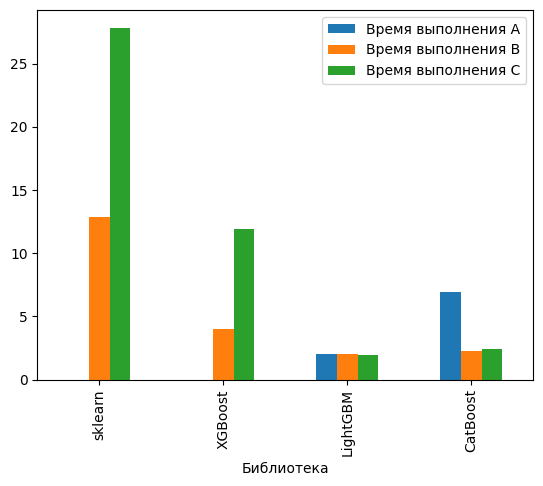

In [ ]:
exectime = pd.DataFrame({'Библиотека': ["sklearn", "XGBoost", "LightGBM", "CatBoost"],
                   'Время выполнения А': [0,
                                          0,
                                          df_lightgbm["Training time"][0] + df_lightgbm["Prediction time"][0],
                                          df_catboost["Training time"][0] + df_catboost["Prediction time"][0]],

                   'Время выполнения В': [df_skl["Training time"][0] + df_skl["Prediction time"][0],
                                          df_xgb["Training time"][0] + df_xgb["Prediction time"][0],
                                          df_lightgbm["Training time"][1] + df_lightgbm["Prediction time"][1],
                                          df_catboost["Training time"][1] + df_catboost["Prediction time"][1]],

                   'Время выполнения С': [df_skl["Training time"][1] + df_skl["Prediction time"][1],
                                          df_xgb["Training time"][1] + df_xgb["Prediction time"][1],
                                          df_lightgbm["Training time"][2] + df_lightgbm["Prediction time"][2],
                                          df_catboost["Training time"][2] + df_catboost["Prediction time"][2]]
                         })
exectime.plot(x='Библиотека', y=['Время выполнения А', 'Время выполнения В', 'Время выполнения С'], kind='bar')
plt.show()

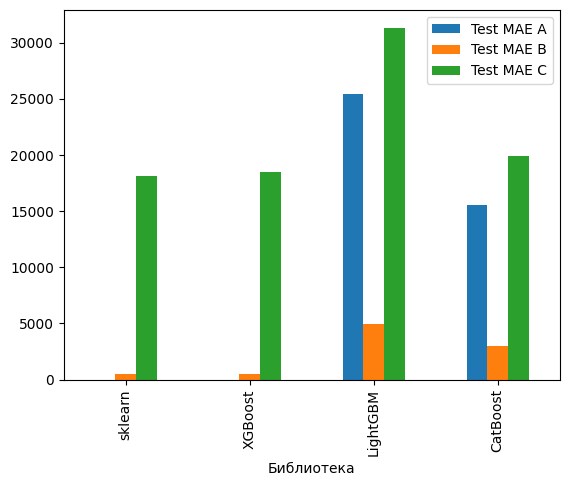

In [ ]:
# Your great pictures and conclusions below!
maeperfomance = pd.DataFrame({'Библиотека': ["sklearn", "XGBoost", "LightGBM", "CatBoost"],
                           'Test MAE А': [0,
                                          0,
                                          df_lightgbm["Test MAE"][0],
                                          df_catboost["Test MAE"][0]],

                           'Test MAE В': [df_skl["Test MAE"][0],
                                          df_xgb["Test MAE"][0],
                                          df_lightgbm["Test MAE"][1],
                                          df_catboost["Test MAE"][1]],

                           'Test MAE С': [df_skl["Test MAE"][1],
                                          df_xgb["Test MAE"][1],
                                          df_lightgbm["Test MAE"][2],
                                          df_catboost["Test MAE"][2]]
                         })
maeperfomance.plot(x='Библиотека', y=['Test MAE А', 'Test MAE В', 'Test MAE С'], kind='bar')
plt.show()

**<font color='magenta'>Выводы:</font>** Графики наглядно демонстрируют, что LightGBM сильно эффективнее остальных библиотек по времени обучения и пресдаказания. И при этом хуже остальных по качеству оценивания.

Однакое хочется замтетить, что в случае B где были исключены категорильные данные лучшее качество предсказания дали библиотеки sklearn и XGBoost



----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

# Оптимизация параметров

И так, мы с вами научились пользоваться библиотеками для градиентного бустинга. Пришло время заняться самой интересной (нет) частью исследований, а именно подбором параметров!

Выберите любые две библиотеки из тех, с которыми мы работали в этом ноутбуке, и осуществите для них перебор параметров по сетке.

Обратите внимание, что:

1. Для всех библиотек вы можете воспользоваться классом `GridSearchCV`, реализованном в `sklearn`, осуществляющим кросс-валидацию всех параметров и поиск модели с лучшим качеством. Этот класс позволяет установить количество разбиений датасета, что достаточно сильно влияет на время работы. Также вы можете воспользоваться `n_jobs = -1` для распараллеливания процесса перебора. <font color='red'>**Внимание!**</font> Если вы устанавливаете n_jobs для GridSearchCV, то не надо использовать этот параметр для обучаемых регрессоров! Результат может быть плачевным в плане времени...
2. В `CatBoost` существует своя реализация перебора параметров, которым также можно воспользоваться (речь о `grid_search`).
3. Для подбора правильной сетки параметров советуем обратиться к краткому руководству в `начале ноутбука.`



### <font color='orange'>**Задание 7.1 (кросс-проверка, 5 баллов)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять `две любые библиотеки градиентного бустинга` (можете взять самые быстрые)
2. Составить `сетку перебора параметров`, включающую не менее трех параметров из n_estimators, max_depth, subsample и learning_rate.
3. Осуществите перебор параметров по вашей сетке при помощи GridSearchCV на `датасетах B и C.` Замерьте `время перебора.` Посчитайте `качество модели `обученной с оптимальными (с позиции кросс-валидации) параметрами на тренировочном и тестовом множествах.
4. `Сделайте выводы` о полезности перебора параметров.

<font color='red'>**Внимание!**</font>

По какой-то причине, которую нам не удалось выяснить, иногда catboost в google colab работает очень медленно при переборе параметров. Если в соответствующем задании время обучения catboost занимает не многим более 10 секунд, то в случае кросс-валидации оно возрастает до 5 минут (соответственно, 5 минут в каждом из узлов). Поэтому используйте catboost на свой страх и риск :)

In [ ]:
df_optimized = pd.DataFrame(columns=['Library', 'Dataset', 'Training time', 'Train MAE', 'Test MAE'])

# your ideal code goes here

estimators = [LGBMRegressor(verbose=0), CatBoostRegressor(verbose=False)]#, GradientBoostingRegressor(verbose=False), XGBRegressor(verbose=False)]

grid = {
    "learning_rate" : [0.01, 0.1, 1],
    "max_depth" : [6, 7, 8],
    "subsample" : [0.5, 0.75, 1],
    "n_estimators" : [900, 1500, 2500]
}

models = []
for j in range(1):
    for i in ["B", "C"]:
        model = GridSearchCV(estimators[j], grid, n_jobs=-1, verbose = 1, scoring='neg_mean_absolute_error')
        start = time.time()
        model.fit(datasets[i][0], datasets[i][2])
        end = time.time()
        y_train_predict = model.predict(datasets[i][0])
        y_predict = model.predict(datasets[i][1])

        models.append(model)
        train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
        test_mae = mean_absolute_error(datasets[i][3], y_predict)
        if j == 0:
            library = "LightGBM"
        else:
            library = "CatBoost"
        df_optimized.loc[len(df_optimized.index)] = [library, i, end - start, train_mae, test_mae]
        print(*[library, i, end - start, train_mae, test_mae])

df_optimized.head()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

,Library,Dataset,Training time,Train MAE,Test MAE
0,LightGBM,B,434.494743,2767.564847,4054.927094
1,LightGBM,C,517.618286,6857.043552,24474.991874


In [ ]:
for j in range(1,2):
    for i in ["B", "C"]:
        model = GridSearchCV(estimators[j], grid, n_jobs=-1, verbose = 1, scoring='neg_mean_absolute_error')
        start = time.time()
        model.fit(datasets[i][0], datasets[i][2])
        end = time.time()
        y_train_predict = model.predict(datasets[i][0])
        y_predict = model.predict(datasets[i][1])

        models.append(model)
        train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
        test_mae = mean_absolute_error(datasets[i][3], y_predict)
        if j == 0:
            library = "LightGBM"
        else:
            library = "CatBoost"
        df_optimized.loc[len(df_optimized.index)] = [library, i, end - start, train_mae, test_mae]
        print(*[library, i, end - start, train_mae, test_mae])

df_optimized.head()

Fitting 5 folds for each of 81 candidates, totalling 405 fits
CatBoost B 3956.831600189209 1117.6301514606118 2489.6313842590416
Fitting 5 folds for each of 81 candidates, totalling 405 fits
CatBoost C 4332.021533250809 3975.7316603489135 16189.728343553792


,Library,Dataset,Training time,Train MAE,Test MAE
0,LightGBM,B,434.494743,2767.564847,4054.927094
1,LightGBM,C,517.618286,6857.043552,24474.991874
2,CatBoost,B,3956.831600,1117.630151,2489.631384
3,CatBoost,C,4332.021533,3975.731660,16189.728344


**<font color='magenta'>Выводы:</font>** Парметры перебирать действительно очень полезно, только долго....

Сравнение с моделями на дефолтных параметрах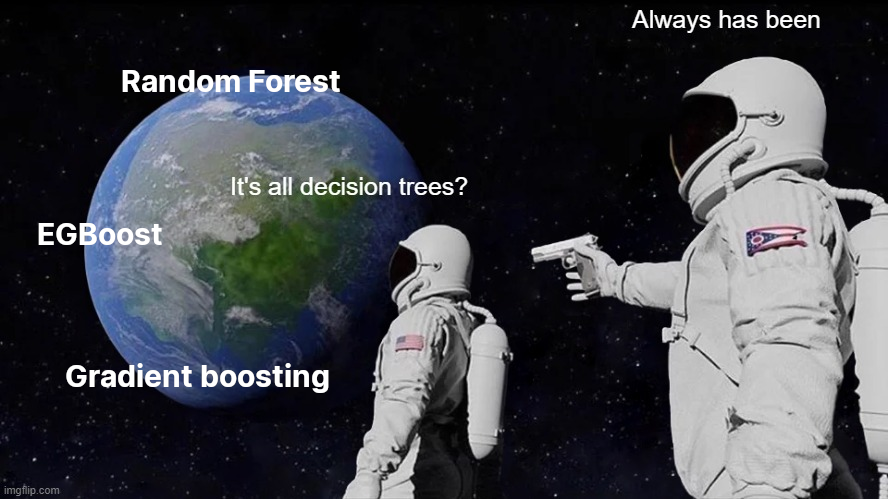 будет ниже

Не знаю почему, но картинка сьехала сюда, хоть я и вставлял ее в конец.

### <font color='orange'>**[Бонус] Задание 7.2 (кросс-проверка, 4 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей  
**Метрика**: MAE  
**Цели**: В данном задании следует выполнить следующие пункты:  
1. Выполнить задание `7.1 с использованием всех библиотек` (для каждой библиотеки можно использовать свою сетку перебора). Разрешается использовать маленькие сетки с небольшим числом узлов, но не менее 8 (под узлом понимается число пересечений в сетке, а не число параметров; итого, для каждого из 3 параметров достаточно перебрать по 2 значения).
1. Вывести ниже `результаты работы` с нашими дефолтными параметрами, а также с оптимальными.
1. Вы будете получать `1 балл за каждую библиотеку` с использованием которой точность с вашими подобранными параметрами `превзойдет качество` с использованием дефолтных параметров на **тренировочной** и **тестовой** выборках. Таким образом, максимальный балл за задание равен числу библиотек, 4 балла.


In [ ]:
# your genious code here
estimators = [GradientBoostingRegressor(), XGBRegressor()]

for j in range(2):
    for i in ["B", "C"]:
        model = GridSearchCV(estimators[j], grid, n_jobs=-1, verbose = 1, scoring='neg_mean_absolute_error')
        start = time.time()
        model.fit(datasets[i][0], datasets[i][2])
        end = time.time()
        y_train_predict = model.predict(datasets[i][0])
        y_predict = model.predict(datasets[i][1])

        models.append(model)
        train_mae = mean_absolute_error(datasets[i][2], y_train_predict)
        test_mae = mean_absolute_error(datasets[i][3], y_predict)
        if j == 0:
            library = "sklearn"
        else:
            library = "xgboost"
        df_optimized.loc[len(df_optimized.index)] = [library, i, end - start, train_mae, test_mae]
        print(*[library, i, end - start, train_mae, test_mae])

df_optimized.head(8)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
sklearn B 4639.539891004562 0.07959147026849704 335.71729668368636
Fitting 5 folds for each of 81 candidates, totalling 405 fits
sklearn C 7511.899493455887 3909.054217530857 17017.927774896707
Fitting 5 folds for each of 81 candidates, totalling 405 fits
xgboost B 2281.2357025146484 42.4049833241959 241.89877972519187
Fitting 5 folds for each of 81 candidates, totalling 405 fits
xgboost C 9123.578134059906 6718.425268434224 16237.05074062682


,Library,Dataset,Training time,Train MAE,Test MAE
0,LightGBM,B,434.494743,2767.564847,4054.927094
1,LightGBM,C,517.618286,6857.043552,24474.991874
2,CatBoost,B,3956.831600,1117.630151,2489.631384
3,CatBoost,C,4332.021533,3975.731660,16189.728344
4,sklearn,B,4639.539891,0.079591,335.717297
5,sklearn,C,7511.899493,3909.054218,17017.927775
6,xgboost,B,2281.235703,42.404983,241.898780
7,xgboost,C,9123.578134,6718.425268,16237.050741


In [ ]:
df_optimized # Оптимизированные результаты

,Library,Dataset,Training time,Train MAE,Test MAE
0,LightGBM,B,434.494743,2767.564847,4054.927094
1,LightGBM,C,517.618286,6857.043552,24474.991874
2,CatBoost,B,3956.831600,1117.630151,2489.631384
3,CatBoost,C,4332.021533,3975.731660,16189.728344
4,sklearn,B,4639.539891,0.079591,335.717297
5,sklearn,C,7511.899493,3909.054218,17017.927775
6,xgboost,B,2281.235703,42.404983,241.898780
7,xgboost,C,9123.578134,6718.425268,16237.050741


In [ ]:
df_unopt #Не оптимизированные результаты

,Library,Dataset,Training time,Train MAE,Test MAE
0,LightGBM,B,1.596886,4646.093537,4971.809759
1,LightGBM,C,1.423350,21020.383955,31347.700217
2,CatBoost,B,2.217090,1975.622948,2964.116435
3,CatBoost,C,2.369801,11182.462234,19895.103270
4,sklearn,B,12.746206,55.369593,459.361295
5,sklearn,C,27.722678,4505.485242,18158.004610
6,xgboost,B,3.893474,88.996870,462.512296
7,xgboost,C,11.850119,5601.384422,18453.964720


In [ ]:
df_lightgbm.insert(0, 'Library', 'LightGBM')
df_catboost.insert(0, 'Library', 'CatBoost')
df_skl.insert(0, 'Library', 'sklearn')
df_xgb.insert(0, 'Library', 'xgboost')

In [ ]:
df_lightgbm = df_lightgbm.drop(0, axis = 0)
df_catboost = df_catboost.drop(0, axis = 0)

In [ ]:
df_unopt = pd.concat([df_lightgbm, df_catboost, df_skl, df_xgb], ignore_index=True)

In [ ]:
df_unopt = df_unopt.drop("Prediction time", axis = 1)

<font color='magenta'>**Ваши пояснения для проверяющих (опционально):**</font> кажется тут и без пояснений видно улучшение всех моделй налицо

df_optimized - результаты оптимизации по gridsearch
df_unopt - результаты с начальными параметрами


А сколько времени ушло на работу перебора гиперпараметров??????

Страшно смотреть

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

Обычнно перебор параметров и поиск по сетке это самая скучная часть работы, поскольку занимает много времени, но не гарантирует воспроизведение результата при небольшом изменении датасета, да и сетку надо переосмысливать при каждом обновлении.

Но сейчас мы поймём, что этого можно избежать, поскольку есть библиотека, которая всё сделает за нас!

Эмоции выполняющего в этот момент.png

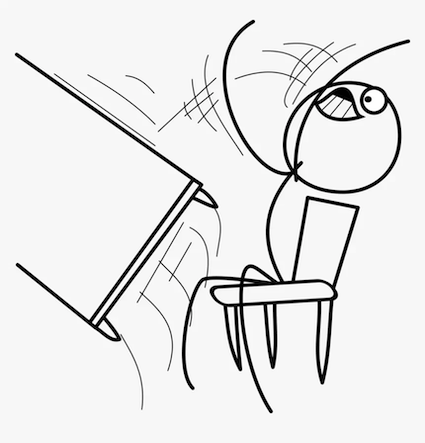

# HyperOpt

Нашего спасителя зовут `HyperOpt.` На первый взгляд hyperopt делает всё то же самое, что и grid search, а именно перебирает параметры. По факту же hyperopt превращает это в задачу оптимизации, используя некоторые эвристики для ускорения сходимости процесса. К тому же, он требует лишь информацию о границе интервалов, а не сами сетки. В теории это должно помочь нам добиться лучших результатов за более короткое время. Давайте попробуем это сделать.

Для данного эксперимента я рекомендую использовать lightgbm, поскольку она быстрее и с ней удобнее играться, но Вы можете воспользоваться любой библиотекой из представленных выше.



### <font color='orange'>**Задание 8 (кросс-проверка, 4 балла)**</font>
**Данные**: датасет со стоимостью подержанных автомобилей

**Метрика**: MAE

**Цели**: В данном задании следует выполнить следующие пункты:
1. Взять `любую библиотеку градиентного бустинга` (можете взять самую быструю)
2. Составить `сетку перебора в hyperopt`, включающую параметры n_estimators, max_depth, subsample и learning_rate в hyperopt. Вам могут понадобиться такие типы данных, как `hp.choice, hp.qloguniform, hp.uniform и hp.quniform`(можно также пользоваться np.arange). Также для округления значения типа float до целых чисел (4.0 -> 4) используйте `scope.int`.
3. `Реализуйте функцию`, которая принимает на вход словарь параметров для регрессора, и при помощи cv оценивает его качество на датасете A (можно воспользоваться cross_val_score, а для ускорения поставить cv=3). Не забудьте о том, в каком виде lightgbm принимает категориальные признаки в numpy и что также надо передавать индексы категориальных признаков.
4. Создайте объект `trials=Trials()`, который будет хранить информацию о процессе оптимизации.
5. Используя функцию fmin, `оптимизируйте Вашу функцию`. Установите algo=tpe.suggest, trials=trials и max_evals, по крайней мере, 50. verbose=1 позволит видеть прогресс-бар по типу tqdm.
6. `Выведите` получившиеся параметры. `Нарисуйте график`, показывающий значение loss в ходе оптимизации. `Посчитайте качество` на тесте при использовании лучших параметров (возвращаются после использования fmin).
7. `Сделайте выводы` по результату.

In [ ]:
estimators = [LGBMRegressor()]#, CatBoostRegressor(verbose=False)]#, GradientBoostingRegressor(verbose=False), XGBRegressor(verbose=False)]

grid = {
    "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 1],
    "max_depth" : [6, 7, 8, 9, 10],
    "subsample" : [0.25, 0.5, 0.75, 1],
    "n_estimators" : [int(i) for i in np.logspace(2.9, 3.6, num=5)]
}
# B) your code goes right here

SPACE = {'learning_rate':
hp.loguniform('learning_rate',np.log(0.001),np.log(1)),
         'max_depth':
hp.choice('max_depth', [i for i in range(6, 14, 1)]),
         'n_estimators':
hp.choice('n_estimators', [1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800]),
         'subsample':
hp.uniform('subsample', 0.1, 1.0)}

trials = Trials()

def objective(params):
    model = LGBMRegressor(n_estimators=params["n_estimators"],
                          max_depth=params["max_depth"],
                          learning_rate=params["learning_rate"],
                          subsample=params["subsample"],
                          verbose=-1)

    res = cross_val_score(model, datasets["A"][0], datasets["A"][2],
                          cv=3,
                          fit_params={"categorical_feature" : "auto"},
                          scoring='neg_mean_absolute_error')
    return -1 * np.mean(res)


result = fmin(objective, SPACE, trials=trials, algo=tpe.suggest, max_evals=100, verbose=1)

100%|██████████| 100/100 [16:02<00:00,  9.62s/trial, best loss: 30057.65168481853]


In [ ]:
result

{'learning_rate': 0.013436103141644645,
 'max_depth': 7,
 'n_estimators': 3,
 'subsample': 0.4777404096124165}

In [ ]:
[i for i in range(1800, 4000, 200)]

[1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800]

In [ ]:
[i for i in range(6, 14, 1)]

[6, 7, 8, 9, 10, 11, 12, 13]

In [ ]:
trials.trials[3]

{'state': 2,
 'tid': 3,
 'spec': None,
 'result': {'loss': 30502.66985912422, 'status': 'ok'},
 'misc': {'tid': 3,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'learning_rate': [3],
   'max_depth': [3],
   'n_estimators': [3],
   'subsample': [3]},
  'vals': {'learning_rate': [0.013072036291039812],
   'max_depth': [4],
   'n_estimators': [6],
   'subsample': [0.4427322799040828]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 3, 12, 14, 13, 16, 904000),
 'refresh_time': datetime.datetime(2024, 3, 12, 14, 13, 29, 187000)}

In [ ]:
ids = [i for i in range(100)]
losses = [trials.trials[i]['result']['loss'] for i in range(100)]

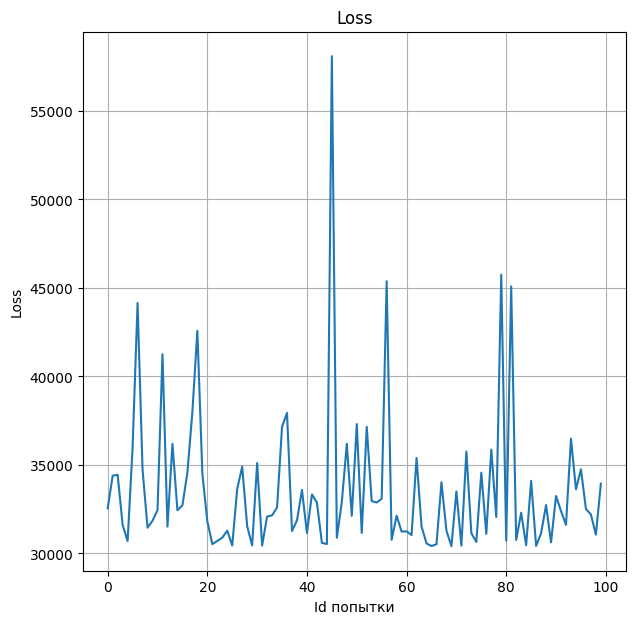

In [ ]:
plt.figure(figsize=(7, 7))
# Отобразим данные
plt.title("Loss")
plt.plot(ids, losses)
plt.xlabel("Id попытки")
plt.ylabel("Loss")

plt.grid()
plt.show()

In [ ]:
df_lightgbm.head(1)

,Dataset,Training time,Prediction time,Train MAE,Test MAE
0,A,1.011588,0.372902,16817.028911,25444.522235


In [ ]:
model = LGBMRegressor(n_estimators=2400,
                      max_depth=13,
                      learning_rate=0.013436103141644645,
                      subsample=0.4777404096124165,
                      verbose=-1)
model.fit(datasets["A"][0], datasets["A"][2], categorical_feature="auto")
y_train_predict = model.predict(datasets["A"][0])
y_predict = model.predict(datasets["A"][1])
train_mae = mean_absolute_error(datasets["A"][2], y_train_predict)
test_mae = mean_absolute_error(datasets["A"][3], y_predict)
["A", train_mae, test_mae]

['A', 14974.950990679168, 19590.826611429766]

**<font color='magenta'>Выводы:</font>** Hyperopt улучшил результат модели LGBMКRegressor по сравнению с начальными параметрами

Вывод: обязательно нужно производить подбор гиперпараметров

# Предсказание зрительских симпатий

Ну что, детишки, а теперь перейдём к действительно важным вопросам.

**<font color='red'>Внимание!</font>** Следующее задание сдается в системе cv-gml.ru, задание `Град. бустинг (ML)` Для выполнения этого задания необходимо скачать датасет из задания. Здесь вы можете немного почитать про датасет и, при желании, поэкспериментировать. На cv-gml.ru загружайте уже готовый скрипт с подобранными параметрами для обучаемого регрессора. Релизовать код необходимо в шаблонном файле `awards_prediction.py`, который вы можете найти в проверяющей системе.

----------------------------------------------
<font color="white" style="opacity:0.2023"></font>

В некотором царстве, некотором государстве была развита кинопромышленность. Новые фильмы в этом государстве показывают по интернету, а пользователи после просмотра могут дать фильму некоторую "награду". Наша цель - предсказать число наград для фильма.

В нашем распоряжении имеются следующие данные:

**awards** - количество наград, полученных фильмом от пользователей (целевое значение)  
**potions** - количество магических зелий, потраченных на создание спец-эффектов  
**genres** - жанры созданного фильма  
**questions** - количество вопросов, заданных пользователями на соответствующих форумах об этом фильме до премьеры  
**directors** - режиссеры фильма (если неизвестны, то unknown)  
**filming_locations** - области, в которых снимался фильм  
**runtime** - продолжительность фильма в некоторых единицах, принятых в этом государстве  
**critics_liked** - количество критиков из 100, присудивших награды фильму на предварительных закрытых показах  
**pre-orders** - количество зрителей, заранее купивших билеты на первый показ  
**keywords** - ключевые слова, описывающие содержание фильма

**release_year** - год, во котором фильм был показан (конечно, в летоисчислении этого государства)

Следующие поля появляются несколько раз с разными значениями i:

**actor_i_known_movies** - количество известных фильмов актера i (i от 0 до 2)

**actor_i_postogramm** - количество подписчиков в социальной сети "по сто грамм" актера i (i от 0 до 2)

**actor_i_gender** - пол актера i (i от 0 до 2)

**actor_i_age** - возраст актера i (i от 0 до 2)

-----
**<font color='red'>Внимание!</font>** Учтите, что при OHE кодировании признаки на обучении и тестировании должны совпадать! Если вы примените простое .get_dummies() или что-то подобное, то признаки на трейне и тесте получатся разные! Так что вам, вероятно, придётся придумать способ для того, чтобы сохранить их :)  

**<font color='red'>Внимание!</font>** Нельзя исключать вероятность того, что злые силы добавили в наш датасет пропуски, поэтому лучше лишний раз как-нибудь заполнить пропущенные значения.

Подсказка: для работы с текстом можно воспользоваться методом TF-IDF (ключевые слова: TfIdfTransformer). Также может быть полезен CountVectorizer. Только учтите, что никто не гарантирует улучшение результата с использованием данных методов  ;)

**<font color='red'>Внимание!</font>** В проверяющей системе имеется проблема с catboost. При использовании этой библиотеки, в скрипте с решением необходимо инициализировать метод с использованием `train_dir` как показано тут:
`CatBoostRegressor(train_dir='/tmp/catboost_info')`

## **<font color='orange'>Задание 9 (ML задание, 27 баллов)</font>**
**Данные**: датасет с наградами за фильмы

**Метрика**: MAE  

**Цели**: В данном задании следует выполнить следующие пункты:  
1. Взять `любую библиотеку градиентного бустинга`
2. Используя предложенный датасет, `обучить регрессор` для предсказания awards (предоставляем полную свободу в настройках и выборе методов)
3. `Загрузить решение` и получить качество на закрытой выборке больше порогового значения

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

texts = ["Soft kitty lyrics:", "Soft kitty, warm kitty", "Little ball of fur", "Happy kitty, sleepy kitty", "Purr, purr, purr"]
tfidf_vectorizer = TfidfVectorizer(sublinear_tf=False)
tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_vectorizer.vocabulary_

{'soft': 9,
 'kitty': 3,
 'lyrics': 5,
 'warm': 10,
 'little': 4,
 'ball': 0,
 'of': 6,
 'fur': 1,
 'happy': 2,
 'sleepy': 8,
 'purr': 7}

In [ ]:
" ".join(texts)

'Soft kitty lyrics: Soft kitty, warm kitty Little ball of fur Happy kitty, sleepy kitty Purr, purr, purr'

In [ ]:
tfidf

<5x11 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_vectorizer.transform([" ".join(texts)]).todense()

matrix([[0.18013923, 0.18013923, 0.18013923, 0.6032067 , 0.18013923,
         0.18013923, 0.18013923, 0.54041768, 0.18013923, 0.29067039,
         0.18013923]])

In [ ]:
tfidf_vectorizer.transform([texts[1]]).todense()

matrix([[0.        , 0.        , 0.        , 0.72164744, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.43468006,
         0.53877474]])

In [ ]:
tfidf.todense()

matrix([[0.        , 0.        , 0.        , 0.4622077 , 0.        ,
         0.69015927, 0.        , 0.        , 0.        , 0.55681615,
         0.        ],
        [0.        , 0.        , 0.        , 0.72164744, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.43468006,
         0.53877474],
        [0.5       , 0.5       , 0.        , 0.        , 0.5       ,
         0.        , 0.5       , 0.        , 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.51339094, 0.68764779, 0.        ,
         0.        , 0.        , 0.        , 0.51339094, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        , 0.        ,
         0.        ]])

In [ ]:
CountVectorizer().fit_transform(texts).todense()

matrix([[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
        [0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0]])

In [ ]:
## your efficient code here

from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from numpy import ndarray
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

"""
 Внимание!
 В проверяющей системе имеется проблема с catboost.
 При использовании этой библиотеки, в скрипте с решением необходимо инициализировать метод с использованием `train_dir` как показано тут:
 CatBoostRegressor(train_dir='/tmp/catboost_info')
"""


"""


    # keywords
    df_train["keywords"] = df_train["keywords"].map(lambda x: " ".join(x))
    df_test["keywords"] = df_test["keywords"].map(lambda x: " ".join(x))

    keywords = list(df_train["keywords"]) + list(df_test["keywords"])
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
    tfidf_vectorizer.fit(keywords)

    s = df_train["keywords"].map(lambda x: tfidf_vectorizer.transform([x]).todense().tolist()[0])
    df_train.join(pd.DataFrame(dict(zip(s.index, s.values))))

    s = df_test["keywords"].map(lambda x: tfidf_vectorizer.transform([x]).todense().tolist()[0])
    df_test.join(pd.DataFrame(dict(zip(s.index, s.values))))
"""


def counter(df, diction=dict()):
    for array in df:
        if array[0] == "u":
            if "unknown" in diction:
                diction['unknown'] += 1
            else:
                diction['unknown'] = 1
            continue
        for elem in array:
            if elem in diction:
                diction[elem] += 1
            else:
                diction[elem] = 1
    return diction


def weighteddict(diction):
    sums = sum(diction.values())
    return {key: (diction[key] / sums) for key in diction.keys()}


def onehotdummy(df, categories):
    res = []
    for row in df:
        hot = [0 for i in range(len(categories) + 1)]
        if row[0] == "u":
            hot[-1] = 1
            res.append(hot)
            continue
        for item in row:
            if item in categories:
                hot[categories.index(item)] = 1
            else:
                hot[-1] = 1
        res.append(hot)
    return pd.DataFrame(res, columns=categories + ["unknown"])


def wordstransform(df_train, df_test, name):
    df_train[name] = df_train[name].map(lambda x: " ".join(x))
    df_test[name] = df_test[name].map(lambda x: " ".join(x))

    keywords = list(df_train[name]) + list(df_test[name])
    tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True)
    tfidf_vectorizer.fit(keywords)

    s = df_train[name].map(lambda x: tfidf_vectorizer.transform([x]).todense().tolist()[0])
    df_train.join(pd.DataFrame(dict(zip(s.index, s.values))))

    s = df_test[name].map(lambda x: tfidf_vectorizer.transform([x]).todense().tolist()[0])
    df_test.join(pd.DataFrame(dict(zip(s.index, s.values))))
    return

def train_model_and_predict(train_file: str, test_file: str) -> ndarray:
    """
    This function reads dataset stored in the folder, trains predictor and returns predictions.
    :param train_file: the path to the training dataset
    :param test_file: the path to the testing dataset
    :return: predictions for the test file in the order of the file lines (ndarray of shape (n_samples,))
    """

    df_train = pd.read_json(train_file, lines=True)
    df_test = pd.read_json(test_file, lines=True)

    # remove categorical variables

    for column in ["genres", "directors", "filming_locations", "keywords"]:
        wordstransform(df_train, df_test, column)
        del df_train[column]
        del df_test[column]

    all_genders = ['Female', 'Male']

    for i in range(3):
        df_train[f"actor_{i}_gender"] = df_train[f"actor_{i}_gender"].map(lambda X: [X])
        df_train.join(onehotdummy(df_train[f"actor_{i}_gender"], all_genders))
        df_test.join(onehotdummy(df_test[f"actor_{i}_gender"].map(lambda X: [X]), all_genders))
        del df_train[f"actor_{i}_gender"]
        del df_test[f"actor_{i}_gender"]

    y_train = df_train["awards"]
    del df_train["awards"]

    SPACE = {'learning_rate':
    hp.loguniform('learning_rate',np.log(0.001),np.log(1)),
         'max_depth':
    hp.choice('max_depth', list(range(5, 11, 1))),
         'n_estimators':
    hp.choice('n_estimators', list(range(800, 4000, 300))),
         'subsample':
    hp.uniform('subsample', 0.1, 1.0)}

    trials = Trials()

    def objective(params):
        model = CatBoostRegressor(n_estimators=params["n_estimators"],
                              max_depth=params["max_depth"],
                              learning_rate=params["learning_rate"],
                              subsample=params["subsample"],
                              verbose=0)

        res = cross_val_score(model, df_train.to_numpy(), y_train.to_numpy(),
                              cv=3,
                              scoring='neg_mean_absolute_error')
                              #fit_params={"categorical_feature" : "auto"})
        return -1 * np.mean(res)


    result = fmin(objective, SPACE, trials=trials, algo=tpe.suggest, max_evals=100, verbose=1)
    print(result)


    regressor = CatBoostRegressor(  # loss_function= "MAE",
                                  # train_dir='/tmp/catboost_info',
                                  n_estimators=list(range(800, 4000, 300))[result["n_estimators"]],
                                  subsample=result["subsample"],
                                  max_depth=list(range(5, 11, 1))[result["max_depth"]],
                                  learning_rate=result["learning_rate"],
                                  verbose=0)
    regressor.fit(df_train.to_numpy(), y_train.to_numpy())
    print(result)
    return regressor.predict(df_test.to_numpy())



In [ ]:
list(range(5, 11, 1))

[5, 6, 7, 8, 9, 10]

In [ ]:
list(range(800, 4000, 300))

[800, 1100, 1400, 1700, 2000, 2300, 2600, 2900, 3200, 3500, 3800]

In [ ]:
import os

In [ ]:
train_file = os.path.join('train.jsonl')
test_file = os.path.join('test.jsonl')

In [ ]:
tfidf_vectorizer.transform([" ".join(['quarantine', 'meaning of life', 'shaving cream', 'armed robbery', 'charter boat'])]).todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [ ]:
predictions = train_model_and_predict(train_file, test_file)

100%|██████████| 100/100 [1:50:35<00:00, 66.35s/trial, best loss: 2250.033781395638]
{'learning_rate': 0.009498262079141704, 'max_depth': 2, 'n_estimators': 5, 'subsample': 0.5915936265134938}
{'learning_rate': 0.009498262079141704, 'max_depth': 2, 'n_estimators': 5, 'subsample': 0.5915936265134938}


In [ ]:
{'learning_rate': 0.0053821892105232845,
 'max_depth': 7,
 'n_estimators': 2300,
 'subsample': 0.46052639109860294}

# <font color='orange'>[Бонус] задание (2 балла)</font>





Найдите мем про градиентный бустинг лучше, чем этот:

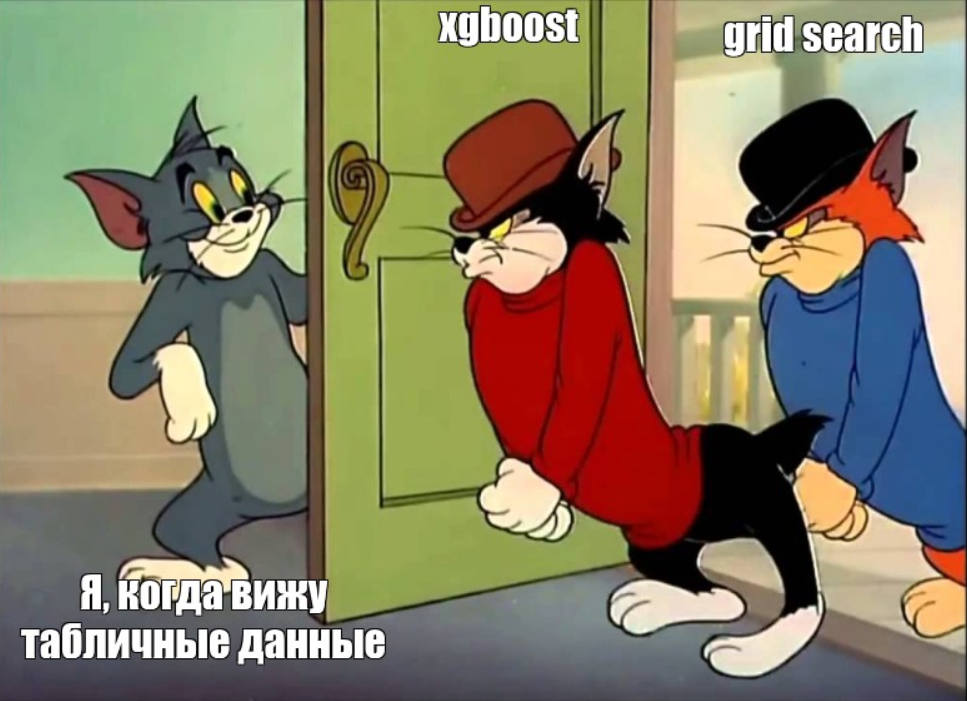


# Конец

Ну что детишки... Можете добавлять еще 4 библиотеки в своё резюме датасаентиста!


```
(╯°□°)╯︵ ┻━┻ FLIP THAT TABLE.

┻━┻ ︵ ヽ(°□°ヽ) FLIP THIS TABLE.

┻━┻ ︵ ＼\('0')/／ ︵ ┻━┻ FLIP ALL THE TABLES

ಠ_ಠ Son... ಠ_ಠ Put. ಠ__ಠ The tables. ಠ___ಠ Back.

(╮°-°)╮┳━┳

(╯°□°)╯︵ ┻━┻ NEVER!!!!
```

